# IMPORTS

In [1]:
from joblib import load
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.base import BaseEstimator, TransformerMixin
import itertools

In [2]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def get_feature_names(self):
        return self.columns

    def transform(self, df, y=None):

        #### One-hot encode str variables #####
        for var in _vars['features']['str'] + _vars['features']['other']:
            #values in train and in test as well
            df = df.assign(**{var: df[var].apply(lambda x: x.replace(' ','_'))})
            df = pd.get_dummies(df, prefix= var, columns=[var])

            #values in train but not in test
            for col in getattr(self, "dummy_values_"+var):
                if col not in df.columns:
                    df[col] = 0

            #values in test but not in train
            for col in [c for c in df.columns.tolist() if c.startswith(var+"_")]:
                if col not in getattr(self, "dummy_values_"+var):
                    df.drop(columns=col, inplace=True)

        #features from : ScheduledDay -> period of the day person has scheduled
        var = 'ScheduledDay'
        df[var + '_weekday'] = df[var].apply(lambda x: x.dayofweek)
        df[var + '_hour_0-6'] = 0
        df[var + '_hour_7-11'] = 0
        df[var + '_hour_12-12'] = 0
        df[var + '_hour_13-17'] = 0
        df[var + '_hour_18-23'] = 0
        df.loc[(df[var].apply(lambda x: 0 <= x.hour) & df[var].apply(lambda x: x.hour <= 6) ), var + '_hour_0-6'] = 1
        df.loc[(df[var].apply(lambda x: 7 <= x.hour) & df[var].apply(lambda x: x.hour <= 11) ), var + '_hour_7-11'] = 1
        df.loc[(df[var].apply(lambda x: 12 <= x.hour) & df[var].apply(lambda x: x.hour <= 12)), var + '_hour_12-12'] = 1
        df.loc[(df[var].apply(lambda x: 13 <= x.hour) & df[var].apply(lambda x: x.hour <= 17)), var + '_hour_13-17'] = 1
        df.loc[(df[var].apply(lambda x: 18 <= x.hour) & df[var].apply(lambda x: x.hour <= 23)), var + '_hour_18-23'] = 1
    
        #features from : AppointmentDay -> day of actual appointement
        var = 'AppointmentDay'
        df[var + '_weekday'] = df[var].apply(lambda x: x.dayofweek)
        df[var + '_month'] = df[var].apply(lambda x: x.month)
    
    
        #number of day between appointement and schedule day
        df['number_days_before_appointment'] = np.maximum((df['AppointmentDay'].dt.date - df['ScheduledDay'].dt.date).dt.days, 0)

        ## DROP ORIGINAL DATETIME VARIABLES
        df.drop(columns=['ScheduledDay', 'AppointmentDay'], inplace=True)

        #df.to_csv('valid_values_df.csv')
        #print("data shape after feature extraction: {}".format(df.shape))

        #save columns header so we can retrieve them later with get_feature_names()
        self.columns = df.columns.tolist()


        return df

    def fit(self, df, y=None):
        """Returns self (unless something different happens in train and test)"""

        #one-hot encode str variables
        for var in _vars['features']['str'] + _vars['features']['other']:
            setattr(self, "dummy_values_"+var, [var + "_"+ value.replace(" ", "_") for value in df[var].unique().tolist()] + [var+"_ValueInTestNotInTrain"])

        return self


# HELPERS FUCNTIONS

In [24]:
N = None
root = "/Users/david/Documents/5_UDEM_machine_learning/1_Machine_learning/project/repo/Project_IFT6390/task2/"  ### to change for other users
project_data_path = "data/"
file_name = 'KaggleV2-May-2016.csv'
metrics = ['accuracy']
scoring_test = metrics

_vars = {
    'features': {
        'int': ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received'],
        'str': ['Gender'],
        'date': ['ScheduledDay', 'AppointmentDay'],
        'other': ['Neighbourhood']
    },
    'label': ['No-show']
}

param_load_data_pandas_from_csv = {
    'function':{
        'shuffle': False
    },
    'data': {
        'common':{
            'usecols': ['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
            'nrows': N,
        },
        'type_specific':{
            'original':{'filepath_or_buffer' :  root + project_data_path + 'original' + '/' + file_name},
            'train':{'filepath_or_buffer' :  root + project_data_path + 'train' + '/' + file_name},
            'test':{'filepath_or_buffer' :  root + project_data_path + 'test' + '/' + file_name},
            'test_unlabel':{
                'filepath_or_buffer' :  root + project_data_path + 'test' + '/' + file_name,
                'usecols': ['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received'],
            }
        }
    }
}

########################################
######### FUNCTIONS DEFINITIONS ########

def load_data_pandas_from_csv(param_data, data_type='train', shuffle=False):
    df = None
    file_name, ext = os.path.splitext(param_data['type_specific'][data_type]['filepath_or_buffer'])
    if ext == '.csv':
        df = pd.read_csv(**{**param_data['common'], **param_data['type_specific'][data_type]})
    elif ext == '.pkl':
        array = np.asarray(np.load(path_data_train, allow_pickle=True), dtype= None).T
        df = pd.DataFrame(array, columns=names)[:nrows]

    if shuffle == True:
        df = df.sample(frac=1, replace=False, random_state=1).reset_index(drop=True)

    return df


def formatting(data, _vars):
    for type, vars in _vars['features'].items():
        if type == 'date':
            for var in vars:
                #datetime format can be easily manipulated for all its components (day, month, year, hour, minute, dayofweek,..)
                data[var] = pd.to_datetime(data[var], infer_datetime_format=True)
        elif type == 'str':
            pass
        elif type == 'int':
            pass
    #label encode target values ( e.g. Yes -> 1, No -> 0 )
    for var in _vars['label']:
        data[var] = np.ravel(label_binarize(data[var], classes=['No', "Yes"]))
    return data


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix - ',
                          cmap=None,
                          normalize=True,
                         model_name=""):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title+model_name)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label\n\nglobal test accuracy={:0.1%}\nprecision class 0 (showed-up)={:0.1%}\nprecision class 1 (no-show)={:0.1%}'.format(accuracy,cm[0,0]/cm[:,0].sum(), cm[1,1]/cm[:,1].sum()))
    plt.show()

# Load test data

In [4]:
data_test = load_data_pandas_from_csv(param_load_data_pandas_from_csv['data'], data_type='test',  **param_load_data_pandas_from_csv['function'])
print("shape of data_test :{}".format(data_test.shape))

shape of data_test :(22106, 12)


In [5]:
#apply formatting
data_test_formatted = formatting(data_test, _vars)

#get feature/label names in lists
features_test = list(data_test_formatted.columns).copy()
label_test = [features_test.pop(features_test.index(lab)) for lab in _vars['label'] if lab in features_test]

# PATHS : model

In [16]:
#paht for results in csv + model(.joblib) (assuming wrt to a scoring chosen e.g. accuracy)
#base_path = '/Users/david/Documents/5_UDEM_machine_learning/1_Machine_learning/project/repo/Project_IFT6390/task2/results/tokeep/'
model_selected = 'RF'
scoring = 'accuracy'

#path = base_path + model_selected + '/'
#path_results = path + 'cv_results_' + model_selected + '_' + scoring + '.xlsx' 
#path_model = "/Users/david/Documents/5_UDEM_machine_learning/1_Machine_learning/project/repo/Project_IFT6390/task2/model_output/notkeep/" \
#              + model_selected + '_' + scoring + '.joblib'  #e.g. path/LR_accuracy.joblib

In [17]:
model = load("./{}_{}.joblib".format(model_selected, scoring))


# PREDICT test data

In [18]:
###################### PREDICT #########################
pred = model.predict(data_test_formatted[features_test])

# Confusion Matrix

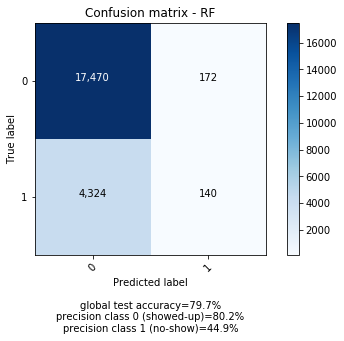

In [34]:
#print(classification_report(data_test_formatted[label_test], pred))
labels = [0, 1]
cm = confusion_matrix(data_test_formatted[label_test], pred, labels)
plot_confusion_matrix(cm,[0,1], normalize=False, model_name = model_selected)

# Feature importances

In [43]:
label_names = ['show-up', 'no-show']

#print(model)
#print(model.best_estimator_.named_steps['feat_extractor'].get_feature_names())
if model_selected == 'LR':
    #print(model.best_estimator_.named_steps['clf'].coef_)
    most_important_features = pd.DataFrame({'var': model.best_estimator_.named_steps['feat_extractor'].get_feature_names(),
                                          'importance': np.ravel(model.best_estimator_.named_steps['clf'].coef_)})
elif model_selected == 'NB':
    pass
elif model_selected == 'RF':
    most_important_features = pd.DataFrame({'var': model.best_estimator_.named_steps['feat_extractor'].get_feature_names(),
                                          'importance': np.ravel(model.best_estimator_.named_steps['clf'].feature_importances_)})    
    #most_important_features =  model.best_estimator_.named_steps['clf'].feature_importances_
    

most_important_features['importance_abs'] =   most_important_features['importance'].abs()
most_important_features_10 = most_important_features.sort_values('importance_abs', ascending=False).head(10)


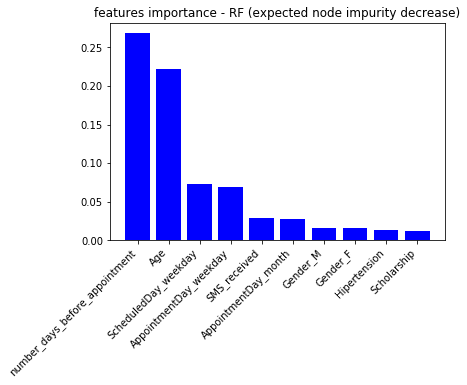

In [49]:
if model_selected == 'LR' and model.best_estimator_.named_steps['clf'].coef_.shape[1]==1:
    colors = np.array(['b']*most_important_features_10.shape[0])
    colors[most_important_features_10['importance'].values<0] = 'r'

    labels = np.array(['show-up']*most_important_features_10.shape[0])
    labels[most_important_features_10['importance'].values<0] = 'no-show'
elif model_selected == 'RF':
    colors = np.array(['b']*most_important_features_10.shape[0])
    #colors[most_important_features_10['importance'].values<0] = 'r'

    labels = np.array(['whatever']*most_important_features_10.shape[0])
    #labels[most_important_features_10['importance'].values<0] = 'no-show'

for i in range(most_important_features_10['var'].shape[0]):
    plt.bar(most_important_features_10['var'].values[i], most_important_features_10['importance_abs'].values[i], color=colors[i], label=labels[i])
plt.xticks(rotation=45, ha="right")

if model_selected == 'RF':
    plt.title('features importance - ' + model_selected +" (expected node impurity decrease)")

if model_selected == 'LR' and model.best_estimator_.named_steps['clf'].coef_.shape[1]==1:
    plt.legend(label_names)

plt.show()